Reproducing the pre-processing of EEG data for ML models with reproduction of earlier work in ming.

# Prepare EEG data for training of machine-learning models

In this notebook, the preprocessing for machine learning purposes is done. Also, some exploration and visualization is done to better understand the data at hand.

+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.
+ Select features

## Import packages & links

In [1]:
# Import packages
import os
import sys

sys.path.insert(0, os.path.dirname(os.getcwd()))

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

sns.set_theme(style="whitegrid")
%matplotlib inline
# %matplotlib qt

In [2]:
import fnmatch
import warnings
import re
warnings.filterwarnings('ignore')

import helper_functions

In [3]:
from config_for_repro_prepro  import PATH_RAW_DATA, PATH_METADATA, PATH_DATA_PROCESSED_ML

In [4]:
# add overwrite step 
PATH_RAW_DATA= 'C:/Projects/EEG_explorer/Data'

## Search all *.cnt files and get paths, code, and age group

In [5]:


# dir_names = {5: '5mnd mmn',
#              11: '11mnd mmn',
#              17: '17mnd mmn',
#              23: '23mnd mmn',
#              29: '29mnd mmn',
#              35: '35mnd mmn',
#              41: '41mnd mmn',
#              47: '47mnd mmn'}

# dir_names = {11: '11mnd mmn',
#              17: '17mnd mmn',
#              23: '23mnd mmn',
#              29: '29mnd mmn',
#              35: '35mnd mmn',
#              41: '41mnd mmn',
#              47: '47mnd mmn',
# }
    
# df_list = []

# for age_group, directory in dir_names.items(): # Go into every age group folder        
#     dir_path = os.path.join('C:/Projects/EEG_explorer/Data', directory)
#     file_names = os.listdir(dir_path)
#     cnt_paths = [os.path.join(dir_path, file_name) for file_name in fnmatch.filter(file_names, "*.cnt")]
#     cnt_files = [x.split('/')[-1][:-4] for x in cnt_paths]
#     codes = [int(re.search(r'\d+', x).group()) for x in cnt_files]
#     df = pd.DataFrame(list(zip(codes, cnt_paths, cnt_files)), columns =['code', 'cnt_path','cnt_file']) 
    
#     df['age_group'] = age_group
#     df_list.append(df)

# cnt_files = pd.concat(df_list)

In [6]:
dir_names = {11: '11mnd mmn',
             17: '17mnd mmn',
             23: '23mnd mmn',
             29: '29mnd mmn',
             35: '35mnd mmn',
             41: '41mnd mmn',
             47: '47mnd mmn'}
    
df_list = []

for age_group, directory in dir_names.items(): # Go into every age group folder        
    dir_path = os.path.join('C:/Projects/EEG_explorer/Data', directory)
    file_names = os.listdir(dir_path)
    
    cnt_paths = [os.path.join(dir_path, file_name) for file_name in fnmatch.filter(file_names, "*.cnt")]
    # list comprehension - creates a list of all cnt file names with thisdirectory
    cnt_files = [os.path.basename(x)[:-4] for x in cnt_paths]
    # list comprehension
    codes = [int(re.search(r'\d+', x).group()) for x in cnt_files]
    # takes number out of string (\d+ takes out digits)
    df = pd.DataFrame(list(zip(codes, cnt_paths, cnt_files)), columns=['code', 'cnt_path','cnt_file']) 
    
    df['age_group'] = age_group
    df_list.append(df)

cnt_files = pd.concat(df_list)

In [7]:
cnt_files.head()

,code,cnt_path,cnt_file,age_group
0,1,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk,11
1,3,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp,11
2,4,C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...,004_11_mc_mmn,11
3,5,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2,11
4,7,C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...,007_11_jc_mmn2_36_wk,11


## Search for all age files and create DataFrame containing all ages per subject code

In [8]:
# age_files = {5: 'ages_5mnths.txt',
#              11: 'ages_11mnths.txt',
#              17: 'ages_17mnths.txt',
#              23: 'ages_23mnths.txt',
#              29: 'ages_29mnths.txt',
#              35: 'ages_35mnths.txt',
#              41: 'ages_41mnths.txt',
#              47: 'ages_47mnths.txt'}

age_files = {11: 'ages_11mnths.txt',
             17: 'ages_17mnths.txt',
             23: 'ages_23mnths.txt',
             29: 'ages_29mnths.txt',
             35: 'ages_35mnths.txt',
             41: 'ages_41mnths.txt',
             47: 'ages_47mnths.txt'}

df_list = []

for age_group, age_file in age_files.items():
    df = pd.read_csv(os.path.join(PATH_METADATA, 'ages', age_file), sep="\t")
    df['age_group'] = age_group
    df_list.append(df)

age_df = pd.concat(df_list)

In [9]:
age_df

,code,age_days,age_months,age_years,age_group
0,1,329,10.966667,0.913889,11
1,3,336,11.200000,0.933333,11
2,5,329,10.966667,0.913889,11
3,6,319,10.633333,0.886111,11
4,7,329,10.966667,0.913889,11
...,...,...,...,...,...
74,731,1409,46.966667,3.913889,47
75,732,1412,47.066667,3.922222,47
76,733,1404,46.800000,3.900000,47
77,734,1405,46.833333,3.902778,47


### Merge the .cnt files with the age information we have on the subjects

In [10]:
#merged_df = pd.merge(age_df, cnt_files, how='left', on=['age_group','code'])

In [11]:
merged_df = pd.merge(cnt_files, age_df, how='left', on=['age_group', 'code'])

In [12]:
merged_df.head()

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,1,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk,11,329.0,10.966667,0.913889
1,3,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp,11,336.0,11.200000,0.933333
2,4,C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...,004_11_mc_mmn,11,NaN,NaN,NaN
3,5,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2,11,329.0,10.966667,0.913889
4,7,C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...,007_11_jc_mmn2_36_wk,11,329.0,10.966667,0.913889


## Visualize the age ranges within groups

In [13]:
data_11 = merged_df.loc[merged_df['age_group'] == 11]
data_17 = merged_df.loc[merged_df['age_group'] == 17]
data_23 = merged_df.loc[merged_df['age_group'] == 23]
data_29 = merged_df.loc[merged_df['age_group'] == 29]
data_35 = merged_df.loc[merged_df['age_group'] == 35]
data_41 = merged_df.loc[merged_df['age_group'] == 41]
data_47 = merged_df.loc[merged_df['age_group'] == 47]
data = [data_11, data_17, data_23, data_29, data_35, data_41, data_47]

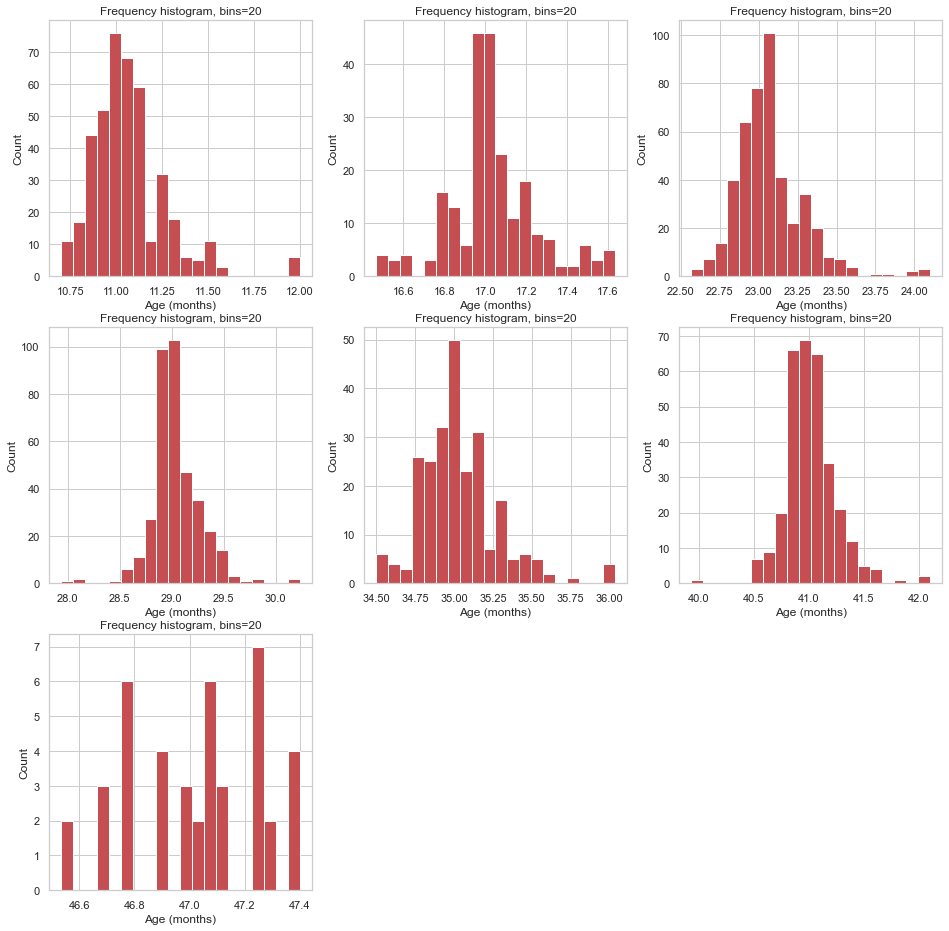

In [14]:
%matplotlib inline

bins = 20

fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:
        ax.hist(data[i]['age_months'], bins=bins, color='r')
        ax.set_xlabel('Age (months)')
        ax.set_ylabel('Count')
        ax.set_title(f'Frequency histogram, bins={bins}')

## Important note: we should examine any discrepancy in numbers from original pro-processing.
Below is a picture from the original pre-processing 

![title](../bjorn_bars.png)

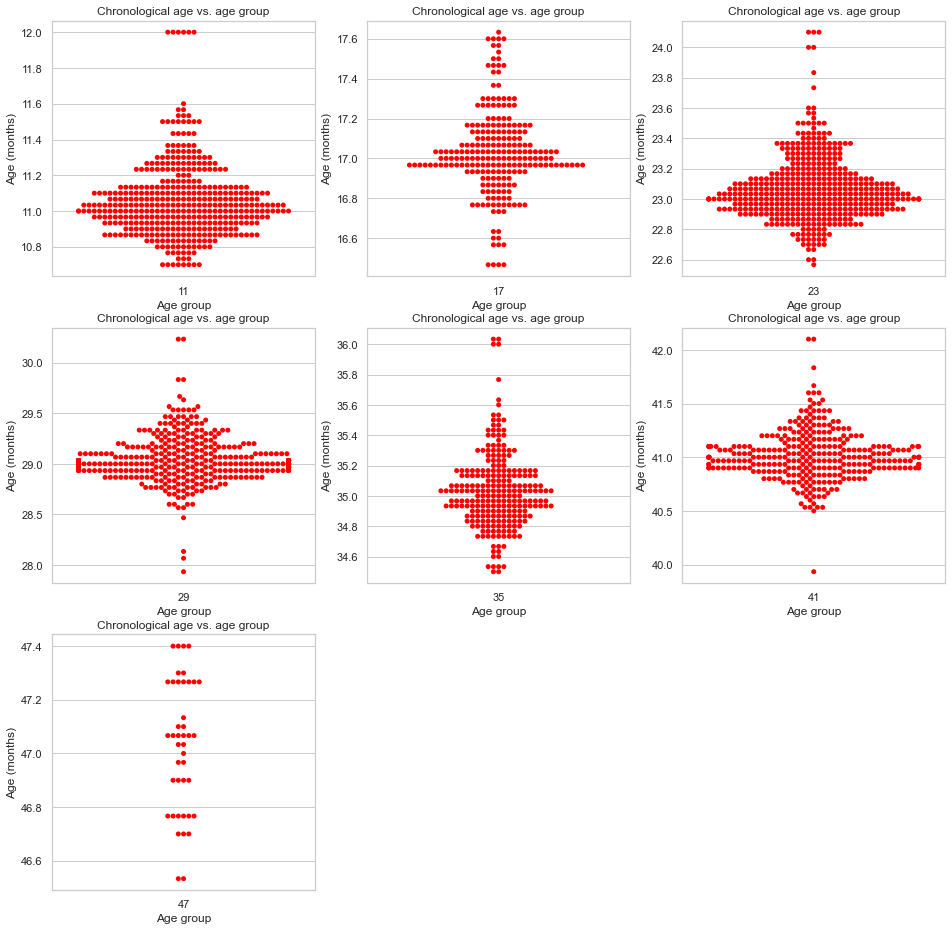

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:
        sns.swarmplot(ax=ax, x="age_group", y="age_months", data=data[i], color = 'red')
        ax.set_xlabel('Age group')
        ax.set_ylabel('Age (months)')
        ax.set_title('Chronological age vs. age group')

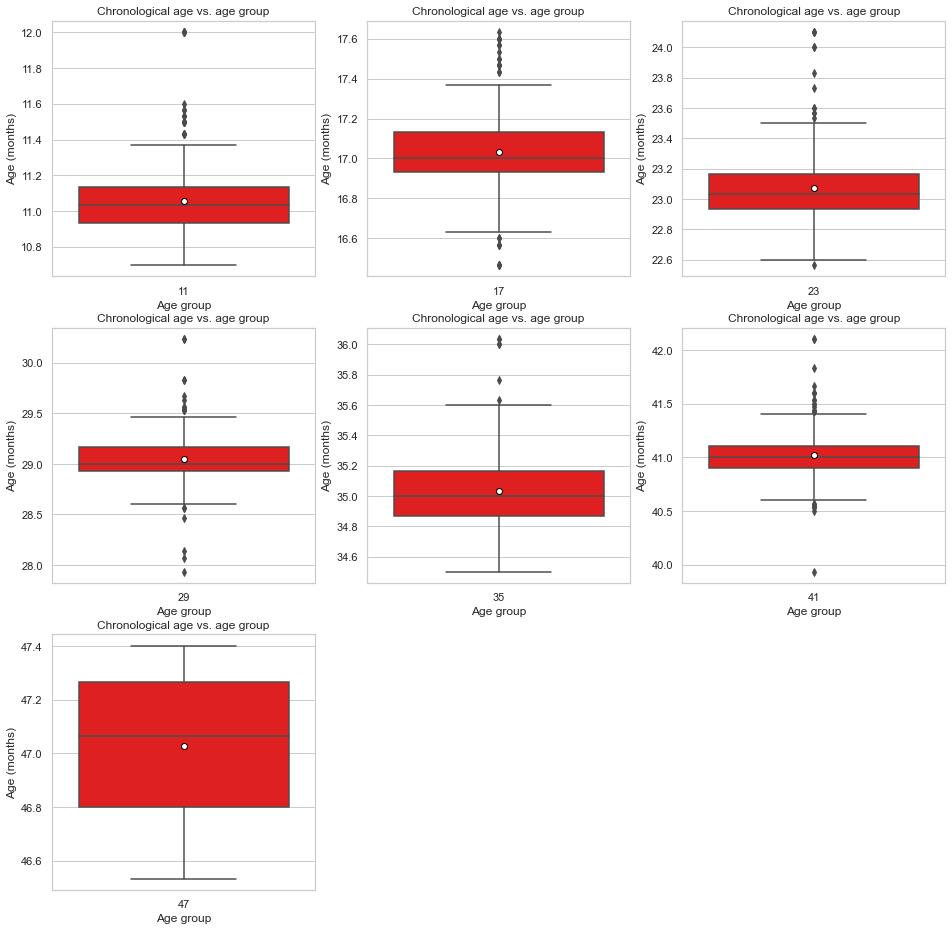

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:    
        sns.boxplot(ax=ax, x="age_group", y="age_months", data=data[i], showmeans=True, 
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                           "markersize":"6"}, color = 'red')
        ax.set_xlabel('Age group')
        ax.set_ylabel('Age (months)')
        ax.set_title('Chronological age vs. age group')

## Check files with no label 

In [17]:
merged_df.loc[merged_df['age_days'].isnull()]

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
2,4,C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...,004_11_mc_mmn,11,NaN,NaN,NaN
9,9,C:/Projects/EEG_explorer/Data\11mnd mmn\009_11...,009_11_jc_mmn36_wk_mmn25_wk,11,NaN,NaN,NaN
10,9,C:/Projects/EEG_explorer/Data\11mnd mmn\009_11...,009_11_jc_mmn47_wk,11,NaN,NaN,NaN
35,31,C:/Projects/EEG_explorer/Data\11mnd mmn\031_11...,031_11_mc_mmn36_wk,11,NaN,NaN,NaN
49,101,C:/Projects/EEG_explorer/Data\11mnd mmn\101_11...,101_11_jr_mmn,11,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1978,433,C:/Projects/EEG_explorer/Data\41mnd mmn\433_41...,433_41_jd_mmn25_slp,41,NaN,NaN,NaN
1979,433,C:/Projects/EEG_explorer/Data\41mnd mmn\433_41...,433_41_jd_mmn36_mix,41,NaN,NaN,NaN
2031,616,C:/Projects/EEG_explorer/Data\41mnd mmn\616-24...,616-240-41m-mc-mmn39,41,NaN,NaN,NaN
2123,119,C:/Projects/EEG_explorer/Data\47mnd mmn\119_47...,119_47_jr_mmn39,47,NaN,NaN,NaN


## Great! WE got exactly the same number of files with missing age labels

### Fill in the missing age data based on the age group the subject is in

We know the age group (i.e. 11, 17, 23, .. months etc) of all the subjects, based on the folder the files are in and based on the file name. We have got the exact ages (in days) of most subjects seperately, which we have added to the DataFrame above. For some of the subjects, we don't have the exact age and therefore we set this equal to the age group.

In [18]:
merged_df['age_months'].fillna(merged_df['age_group'], inplace=True)
merged_df['age_days'].fillna(merged_df['age_group']*30, inplace=True)
merged_df['age_years'].fillna(merged_df['age_group']/12, inplace=True)

Below should now return an empty dataframe, because all empty fields have been filled

In [19]:
merged_df.loc[merged_df['age_days'].isnull()]

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years


In [20]:
merged_df

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,1,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk,11,329.0,10.966667,0.913889
1,3,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp,11,336.0,11.200000,0.933333
2,4,C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...,004_11_mc_mmn,11,330.0,11.000000,0.916667
3,5,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2,11,329.0,10.966667,0.913889
4,7,C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...,007_11_jc_mmn2_36_wk,11,329.0,10.966667,0.913889
...,...,...,...,...,...,...,...
2144,704,C:/Projects/EEG_explorer/Data\47mnd mmn\704-03...,704-032-47m-jr-mmn36,47,1422.0,47.400000,3.950000
2145,705,C:/Projects/EEG_explorer/Data\47mnd mmn\705-05...,705-050-47m-jr-mmn36,47,1407.0,46.900000,3.908333
2146,709,C:/Projects/EEG_explorer/Data\47mnd mmn\709-07...,709-078-47m-jr-mmn36,47,1419.0,47.300000,3.941667
2147,710,C:/Projects/EEG_explorer/Data\47mnd mmn\710-07...,710-078-47m-jr-mmn36,47,1412.0,47.066667,3.922222


## But we don't get the same number of files...discussed in data_overview notebook

## Explore EEG data

### Import EEG data (from .cnt files)

In [21]:
# Select a file
file = merged_df['cnt_path'][500] # just a random file number

# Import file 
data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True)

Reading 0 ... 1497319  =      0.000 ...  2994.638 secs...


## What does the data look like?

In [22]:
print('Data type: {}\n\n{}\n'.format(type(data_raw), data_raw))

# Get the sample rate
print('Sample rate:', data_raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(data_raw.get_data().shape))

# The mne.info class can be used to learn more about the data.
print(data_raw.info)

Data type: <class 'mne.io.cnt.cnt.RawCNT'>

<RawCNT | 119_17_jr_mmn.cnt, 64 x 1497320 (2994.6 s), ~731.2 MB, data loaded>

Sample rate: 500.0 Hz
Size of the matrix: (64, 1497320)

<Info | 8 non-empty values
 bads: []
 ch_names: O2, O1, OZ, PZ, P4, CP4, P8, C4, TP8, T8, P7, P3, CP3, CPZ, CZ, ...
 chs: 62 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>


### Show data as pandas dataframe (i.e. as a table).
The raw data itself is just an array dimensions are no. of channels and timepoint.

In [23]:
raw_df = data_raw.to_data_frame()
raw_df.head()

,time,O2,O1,OZ,PZ,P4,CP4,P8,C4,TP8,...,F2,F6,FC5,F1,AF4,AF8,F5,AF7,AF3,FPZ
0,0,175.054330,29.468177,150.890922,286.713284,415.074493,291.448520,178.184993,175.347231,91.880159,...,229.772628,137.177278,11.968776,68.487220,128.269314,115.574839,7.313887,-27.772926,-47.252270,177.356866
1,2,185.658416,30.514385,158.192096,272.027969,414.373353,292.321120,177.661433,186.631953,87.190623,...,239.210638,148.881236,19.774500,78.370186,140.353906,128.069416,-5.398345,-13.624454,-42.059713,190.615583
2,4,194.350289,32.781167,163.233382,266.433563,414.548638,293.542760,178.708553,197.569454,84.932699,...,247.790646,158.691907,26.192539,87.386225,149.503668,135.357919,-3.308663,-1.572052,-27.866723,202.324580
3,6,199.043901,36.791629,166.188619,269.580417,417.002626,295.462481,180.977314,204.687510,85.627445,...,251.909050,162.134248,30.529052,91.200703,151.920587,134.837312,10.274270,3.842795,-14.539160,206.629358
4,8,200.086926,40.802091,168.100832,276.398598,420.858892,298.254802,182.198955,207.986121,88.059056,...,251.051049,158.691907,35.559408,89.640235,148.640483,129.457702,26.643445,3.668122,-11.250541,204.390874


In [24]:
data_raw.info['bads']

[]

In [25]:
# Band-pass filter (between 1 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
data_raw.filter(1, 40, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



<RawCNT | 119_17_jr_mmn.cnt, 64 x 1497320 (2994.6 s), ~731.2 MB, data loaded>

### Plot channels

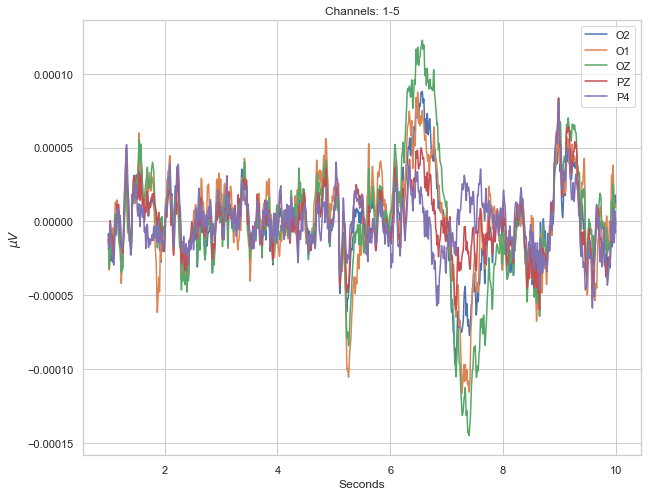

In [26]:
# Extract data from the first 5 channels, from 1 s to 10 s.
sfreq = data_raw.info['sfreq']
data, times = data_raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T)
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5')
plt.legend(data_raw.ch_names[:5])

## We now get about the same picture (see other site)

### mne plots
There are many nice plotting options included in mne. They are, however, not always interactive and fully functional in Jupyter notebooks... so better try them out from a python script.

In [27]:
data_raw.plot(duration=10, block=True)

Using qt as 2D backend.
Opening raw-browser...
Closing raw-browser...
Channels marked as bad:
none


## In our case we made a pop-out window, but an EEG is there.

### Look at events 

In [28]:
# get the events
events, event_id = mne.events_from_annotations(data_raw)
print(events[:10,:])
print(event_id)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
[[ 7684     0     5]
 [ 8410     0     5]
 [ 9136     0     5]
 [ 9858     0     5]
 [10584     0     5]
 [11310     0     5]
 [12036     0     3]
 [12762     0     7]
 [13488     0     5]
 [14214     0     5]]
{'0': 1, '12': 2, '13': 3, '2': 4, '3': 5, '55': 6, '66': 7}


In [29]:
# Check which unique event indentifiers there are
unique_event_types = set(events[:,2])
print(unique_event_types)

{1, 2, 3, 4, 5, 6, 7}


## It's a match.

### Search for most common event

In [30]:
tmin = -0.2
tmax = 0.8

baseline = (None, 0)  # means from the first instant to t = 0
counts = pd.Series()

for i, path in enumerate(merged_df['cnt_path']):        
    # Import file 
    try:
        raw = mne.io.read_raw_cnt(path, eog='auto', preload=True, verbose=False)
    except: 
        continue
    
    # Load events
    events_count, event_id_count = mne.events_from_annotations(raw, verbose=False)    
    event_id_count = {y:x for x,y in event_id_count.items()}
    
    temp_df = pd.DataFrame(events_count) 
    temp_df[2].replace(event_id_count, inplace=True)
    counts = counts.add(temp_df[2].value_counts(),fill_value=0)

print(counts)

# 0        3567.0
# 1       13263.0
# 10         18.0
# 104         1.0
# 11         12.0
# 112         2.0
# 12      44920.0
# 127       304.0
# 13     120790.0
# 14       8649.0
# 15       6600.0
# 16         13.0
# 17         13.0
# 18         93.0
# 19         75.0
# 2      357282.0
# 20         15.0
# 201         2.0
# 202         2.0
# 203         2.0
# 204         2.0
# 205         2.0
# 206         2.0
# 208         2.0
# 209         2.0
# 21         10.0
# 210         2.0
# 211         2.0
# 255         2.0
# 26          1.0
# 27          1.0
# 3      878840.0
# 31          1.0
# 33        614.0
# 35          1.0
# 36          2.0
# 4       72045.0
# 40         12.0
# 41          4.0
# 45          1.0
# 48         18.0
# 49         10.0
# 5       55476.0
# 55      44602.0
# 58          5.0
# 6          12.0
# 60          9.0
# 65          5.0
# 66      91848.0
# 7          12.0
# 72          4.0
# 73          7.0
# 77       8969.0
# 8          13.0
# 80         62.0
# 81         31.0
# 82          8.0
# 88       6894.0
# 9          12.0
# 99      28749.0
# dtype: float64

0        3523.0
1        5202.0
10         18.0
104         1.0
11         12.0
112         2.0
12      44653.0
127       304.0
13     120522.0
14       8608.0
15       6573.0
16         13.0
17         13.0
18         93.0
19         75.0
2      355167.0
20         15.0
201         2.0
202         2.0
203         2.0
204         2.0
205         2.0
206         2.0
208         2.0
209         2.0
21         10.0
210         2.0
211         2.0
255         2.0
26          1.0
27          1.0
3      876908.0
31          1.0
33        614.0
35          1.0
36          2.0
4       71706.0
40         12.0
41          4.0
45          1.0
48         18.0
49         10.0
5       55252.0
55      44337.0
58          5.0
6          12.0
60          9.0
65          5.0
66      91654.0
7          12.0
72          4.0
73          7.0
77       8928.0
8          13.0
80         62.0
81         31.0
82          8.0
88       6867.0
9          12.0
99      28676.0
dtype: float64


In [31]:
#previous_common_events = pd.read_csv('../bjorn_common_events.txt')
#previous_common_events


old_set1= '../bjorn_common_events.txt'
with open(old_set1, 'r') as text:
    textfile = text.read()
    print(textfile)

0        3567.0
1       13263.0
10         18.0
104         1.0
11         12.0
112         2.0
12      44920.0
127       304.0
13     120790.0
14       8649.0
15       6600.0
16         13.0
17         13.0
18         93.0
19         75.0
2      357282.0
20         15.0
201         2.0
202         2.0
203         2.0
204         2.0
205         2.0
206         2.0
208         2.0
209         2.0
21         10.0
210         2.0
211         2.0
255         2.0
26          1.0
27          1.0
3      878840.0
31          1.0
33        614.0
35          1.0
36          2.0
4       72045.0
40         12.0
41          4.0
45          1.0
48         18.0
49         10.0
5       55476.0
55      44602.0
58          5.0
6          12.0
60          9.0
65          5.0
66      91848.0
7          12.0
72          4.0
73          7.0
77       8969.0
8          13.0
80         62.0
81         31.0
82          8.0
88       6894.0
9          12.0
99      28749.0
dtype: float64


## OK so here we see a very different distribution. Interesting.

### Display signal around one type of event
Selects signal for specific event ID and plots time window from tmin to tmax.

In [55]:
# event_id = [1, 2, 3, 4] # select events for the given event IDs
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

baseline = (None, 0)  # means from the first instant to t = 0
picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

print(picks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [56]:
epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=baseline, preload=True, verbose=True)

print(epochs)

Not setting metadata
2012 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2012 events and 351 original time points ...
0 bad epochs dropped
<Epochs |  2012 events (all good), -0.2 - 0.5 sec, baseline -0.2 – 0 sec, ~334.1 MB, data loaded,
 '0': 12
 '12': 100
 '13': 100
 '2': 800
 '3': 800
 '55': 100
 '66': 100>


In [57]:
# Export data in tabular structure as a pandas DataFrame.
epochs_df = epochs.to_data_frame()
epochs_df.head()

,time,condition,epoch,O2,O1,OZ,PZ,P4,CP4,P8,...,F2,F6,FC5,F1,AF4,AF8,F5,AF7,AF3,FPZ
0,-200,3,0,19.733487,22.597901,20.047278,11.217764,2.835124,7.186990,-4.227798,...,0.470223,-7.124972,2.163766,2.438343,2.643083,2.230914,6.519844,1.897849,2.119677,0.088040
1,-198,3,0,20.655105,23.620044,21.116976,12.893161,4.508536,8.701691,-3.361994,...,3.613162,-4.806182,2.521073,5.027857,5.431945,5.048605,7.564638,3.832950,4.351600,1.953257
2,-196,3,0,21.837246,24.527912,22.449666,14.617161,6.066433,9.963521,-2.762263,...,6.810397,-2.267107,3.239110,7.844382,8.297986,7.850240,9.621177,6.715257,6.696419,4.096949
3,-194,3,0,23.185903,25.159274,23.834357,16.295032,7.396069,10.996093,-2.481381,...,9.839636,0.406558,4.405409,10.674934,11.066978,10.475421,12.428237,10.308709,9.007766,6.491404
4,-192,3,0,24.521683,25.356660,24.990797,17.801691,8.419938,11.847577,-2.519168,...,12.475150,3.079324,6.023836,13.294821,13.559116,12.794901,15.606350,14.251309,11.168117,9.045967


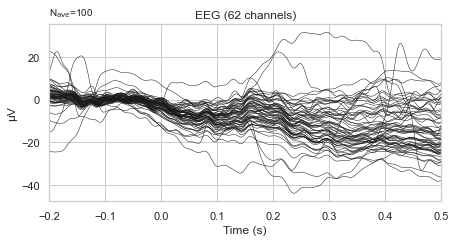

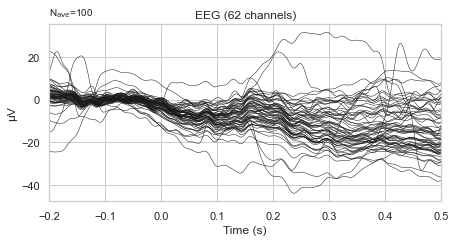

In [58]:
evoked = epochs['66'].average()
evoked.plot()

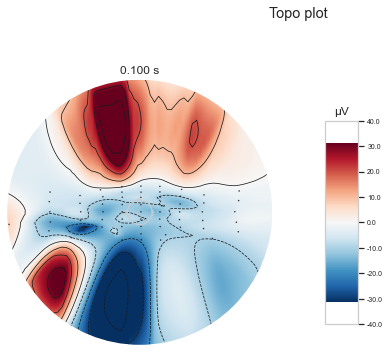

In [59]:
# Spatial plot:
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

### Plot topomaps for different time points

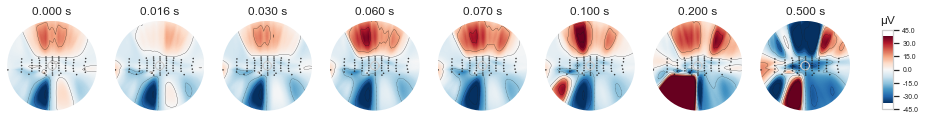

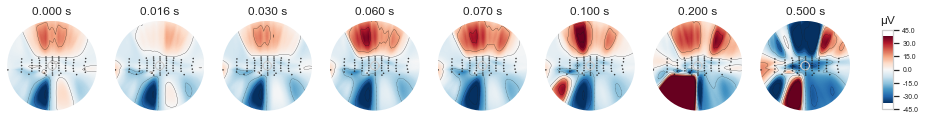

In [60]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

### Test other event type

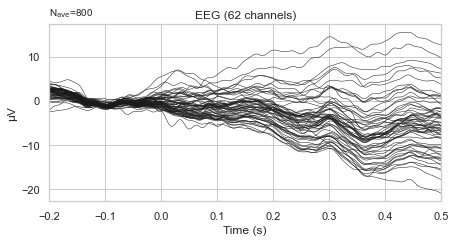

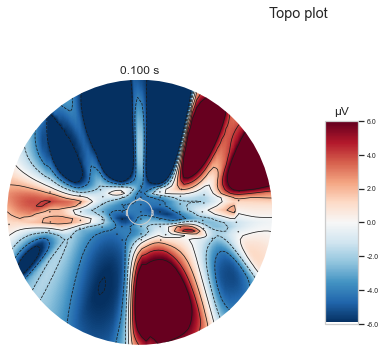

In [61]:
evoked = epochs['3'].average()
evoked.plot()
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

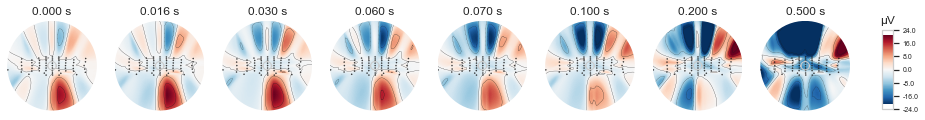

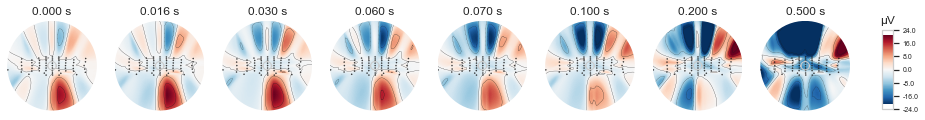

In [62]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

# Adding a montage to the data

Montages specify the exact electrode placement on the scalp of the subject. This contains coordinates relative to a point on the scalp. Often this data is included in the EEG data (.cnt file). Unfortunately for us, we don't have this information. The electrode placement information can be used to fix broken channels by using the channels surrounding this channel. Even though we don't have the exact locations, we do know the electrode placement system used: 10-20. We can use this to approximate the locations.

### When looking at the maps above, the electrode placement seems to be incorrect

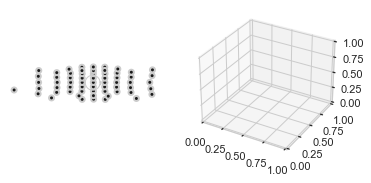

In [63]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
data_raw.plot_sensors(ch_type='eeg', axes=ax2d)
data_raw.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

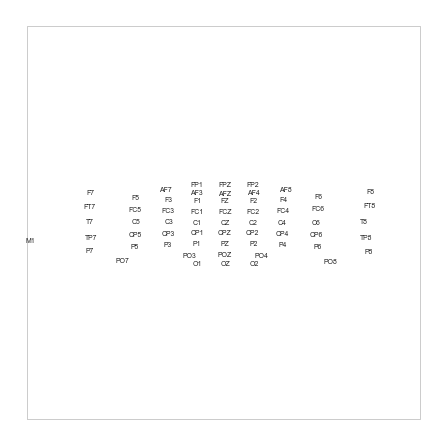

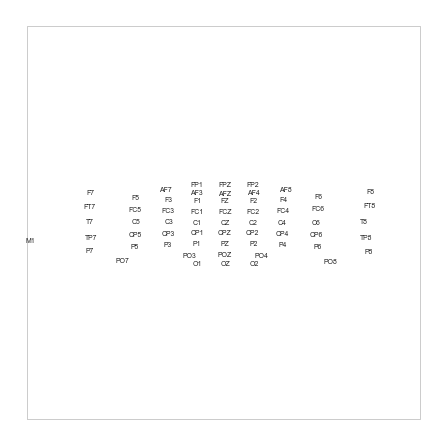

In [64]:
layout_from_raw = mne.channels.make_eeg_layout(data_raw.info)
layout_from_raw.plot()

### Unfortunately, we don't have the exact sensor locations. Therefore, we try to approximate them with a standard montage.

Standard montages come with the mne package. They're based on well known and often used electrode placement systems (10-20 in our case).

In [65]:
print(data_raw.ch_names)

['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'HEOG', 'VEOG', 'AFZ', 'PO3', 'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']


In [66]:
len(data_raw.ch_names)

64

In [67]:
montage = mne.channels.make_standard_montage('standard_1020')
montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


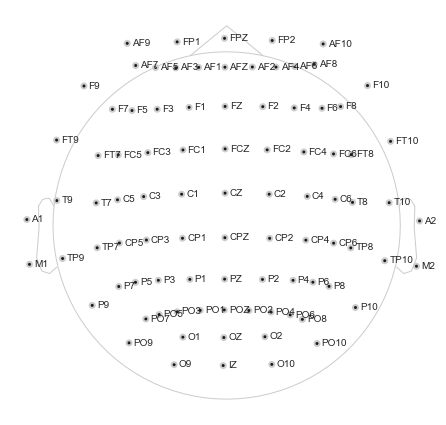

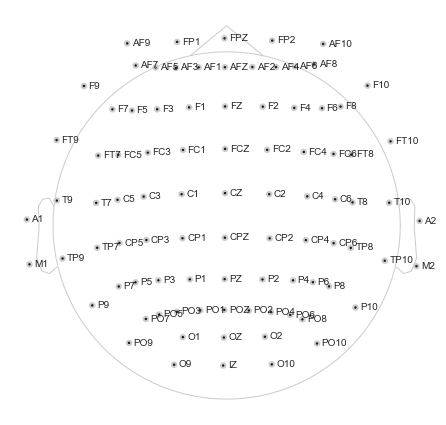

In [68]:
montage.plot(kind='topomap', show_names=True)

In [69]:
data_raw_1020 = data_raw.copy().set_montage(montage)

### Now, after setting the 1020 montage, the maps look different

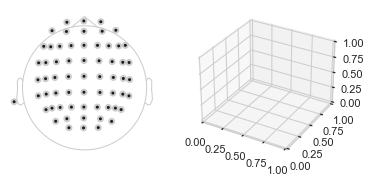

In [70]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
data_raw_1020.plot_sensors(ch_type='eeg', axes=ax2d)
data_raw_1020.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

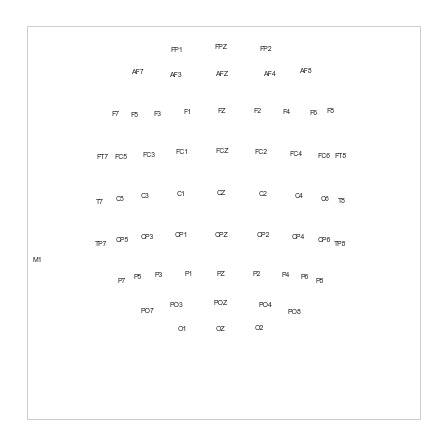

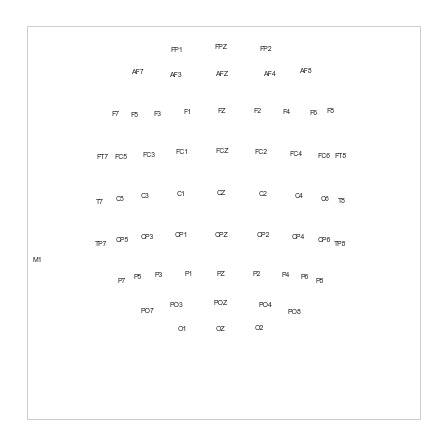

In [71]:
layout_from_raw = mne.channels.make_eeg_layout(data_raw_1020.info)
layout_from_raw.plot()

## Custom cnt-file import function:

In [72]:
def read_cnt_file_b(file,
                  label_group,
                  event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                  channel_set = "30",
                  tmin = -0.2,
                  tmax = 0.8,
                  lpass = 0.5, 
                  hpass = 40, 
                  threshold = 5, 
                  max_bad_fraction = 0.2,
                  max_bad_channels = 2):
    """ Function to read cnt file. Run bandpass filter. 
    Then detect and correct/remove bad channels and bad epochs.
    Store resulting epochs as arrays.
    
    Args:
    --------
    file: str
        Name of file to import.
    label_group: int
        Unique ID of specific group (must be >0).
    channel_set: str
        Select among pre-defined channel sets. Here: "30" or "62"
    """
    
    if channel_set == "30":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']
    elif channel_set == "62":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 
                       'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 
                       'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 
                       'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']
    else:
        print("Predefined channel set given by 'channel_set' not known...")
        
    
    # Initialize array
    signal_collection = np.zeros((0,len(channel_set),501))
    label_collection = [] #np.zeros((0))
    channel_names_collection = []
    
    # Import file
    try:
        data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True, verbose=False)
    except ValueError:
        print("ValueError")
        print("Could not load file:", file)
        return None, None, None
    
    # Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
    data_raw.filter(0.5, 40, fir_design='firwin')

    # Get events from annotations in the data
    events_from_annot, event_dict = mne.events_from_annotations(data_raw)
    
    # Set baseline:
    baseline = (None, 0)  # means from the first instant to t = 0

    # Select channels to exclude (if any)
    channels_exclude = [x for x in data_raw.ch_names if x not in channel_set]
    channels_exclude = [x for x in channels_exclude if x not in ['HEOG', 'VEOG']]
    
    for event_id in event_idx:
        if str(event_id) in event_dict:
            # Pick EEG channels
            picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                               #exclude=data_exclude)#'bads'])
                                   include=channel_set, exclude=channels_exclude)#'bads'])

            epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                baseline=baseline, preload=True, event_repeated='merge', verbose=False)

            # Detect potential bad channels and epochs
            bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs,
                                                                          event_id,
                                                                          threshold = threshold,
                                                                          max_bad_fraction = max_bad_fraction)

            # Interpolate bad channels
            # ------------------------------------------------------------------
            if len(bad_channels) > 0:
                if len(bad_channels) > max_bad_channels:
                    print(20*'--')
                    print("Found too many bad channels (" + str(len(bad_channels)) + ")")
                    return None, None, None
                else:
                    # MARK: Setting the montage is not verified yet (choice of standard montage)
                    montage = mne.channels.make_standard_montage('standard_1020')
                    montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]
                    data_raw.set_montage(montage)
                    
                    # TODO: Think about using all channels before removing (62 -> 30), to enable for better interpolation
                    
                    # Mark bad channels:
                    data_raw.info['bads'] = bad_channels
                    # Pick EEG channels:
                    picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       #exclude=data_exclude)#'bads'])
                                       include=channel_set, exclude=channels_exclude)#'bads'])
                    epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                        tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                        baseline=baseline, preload=True, verbose=False)
                    
                    # Interpolate bad channels using functionality of 'mne'
                    epochs.interpolate_bads()
                    

            # Get signals as array and add to total collection
            channel_names_collection.append(epochs.ch_names)
            signals_cleaned = epochs[str(event_id)].drop(bad_epochs).get_data()
            signal_collection = np.concatenate((signal_collection, signals_cleaned), axis=0)
            label_collection += [event_id + label_group] * signals_cleaned.shape[0]

    return signal_collection, label_collection, channel_names_collection

In [73]:
def read_cnt_file(file,
                  label_group,
                  event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                  channel_set = "30",
                  tmin = -0.2,
                  tmax = 0.8,
                  lpass = 0.5, 
                  hpass = 40, 
                  threshold = 5, 
                  max_bad_fraction = 0.2,
                  max_bad_channels = 2):
    """ Function to read cnt file. Run bandpass filter. 
    Then detect and correct/remove bad channels and bad epochs.
    Store resulting epochs as arrays.
    
    Args:
    --------
    file: str
        Name of file to import.
    label_group: int
        Unique ID of specific group (must be >0).
    channel_set: str
        Select among pre-defined channel sets. Here: "30" or "62"
    """
    
    if channel_set == "30":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']
    elif channel_set == "62":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 
                       'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 
                       'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 
                       'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']
    else:
        print("Predefined channel set given by 'channel_set' not known...")
        
    
    # Initialize array
    signal_collection = np.zeros((0,len(channel_set),501))
    label_collection = [] #np.zeros((0))
    channel_names_collection = []
    
    # Import file
    try:
        data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True, verbose=False)
    except ValueError:
        print("ValueError")
        print("Could not load file:", file)
        return None, None, None
    
    # Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
    data_raw.filter(0.5, 40, fir_design='firwin')

    # Get events from annotations in the data
    events_from_annot, event_dict = mne.events_from_annotations(data_raw)
    
    # Set baseline:
    baseline = (None, 0)  # means from the first instant to t = 0

    # Select channels to exclude (if any)
    channels_exclude = [x for x in data_raw.ch_names if x not in channel_set]
    channels_exclude = [x for x in channels_exclude if x not in ['HEOG', 'VEOG']]
    
    for event_id in event_idx:
        if str(event_id) in event_dict:
            # Pick EEG channels
            picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                               #exclude=data_exclude)#'bads'])
                                   include=channel_set, exclude=channels_exclude)#'bads'])

            epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                baseline=baseline, preload=True, event_repeated='merge', verbose=False)

            # Detect potential bad channels and epochs
            bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs,
                                                                          event_id,
                                                                          threshold = threshold,
                                                                          max_bad_fraction = max_bad_fraction)

            # Interpolate bad channels
            # ------------------------------------------------------------------
            if len(bad_channels) > 0:
                if len(bad_channels) > max_bad_channels:
                    print(20*'--')
                    print("Found too many bad channels (" + str(len(bad_channels)) + ")")
                    return None, None, None
                else:
                    # MARK: Setting the montage is not verified yet (choice of standard montage)
                    montage = mne.channels.make_standard_montage('standard_1020')
                    montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]
                    data_raw.set_montage(montage)
                    
                    # TODO: Think about using all channels before removing (62 -> 30), to enable for better interpolation
                    
                    # Mark bad channels:
                    data_raw.info['bads'] = bad_channels
                    # Pick EEG channels:
                    picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       #exclude=data_exclude)#'bads'])
                                       include=channel_set, exclude=channels_exclude)#'bads'])
                    epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                        tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                        baseline=baseline, preload=True, verbose=False)
                    
                    # Interpolate bad channels using functionality of 'mne'
                    epochs.interpolate_bads()
                    

            # Get signals as array and add to total collection
            channel_names_collection.append(epochs.ch_names)
            signals_cleaned = epochs[str(event_id)].drop(bad_epochs).get_data()
            signal_collection = np.concatenate((signal_collection, signals_cleaned), axis=0)
            label_collection += [event_id + label_group] * signals_cleaned.shape[0]

    return signal_collection, label_collection, channel_names_collection

In [74]:
signal_collect, label_collect, channel_names_collection = read_cnt_file(merged_df['cnt_path'][20], 
                                                                        merged_df['age_months'][0],
                                                                        event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                                        channel_set = "30",
                                                                        tmin = -0.2,
                                                                        tmax = 0.8,
                                                                        lpass = 0.5, 
                                                                        hpass = 40, 
                                                                        threshold = 5, 
                                                                        max_bad_fraction = 0.2,
                                                                        max_bad_channels = 2)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
No outliers found with given threshold.
Dropped 0 epochs: 
Found 38 bad epochs in a total of 14  channels.
Marked 38 bad epochs in a total of 560  epochs.
Dropped 38 epochs: 4, 27, 29, 90, 95, 114, 118, 181, 196, 207, 214, 222, 225, 228, 234, 235, 236, 241, 244, 249, 251, 252, 254, 259, 262, 272, 284, 290, 299, 314, 320, 342, 3

In [75]:
signal_collect.shape

(1917, 30, 501)

In [76]:
len(label_collect)

1917

In [77]:
signal_collect.shape , #label_collect.shape

((1917, 30, 501),)

 label_collection, label_collect? We had a variable that in the original produced 329, as a shape. but our label_collect is 1917 long

In [78]:
### Here we see the previous had a variable based on delted code...we can't do much

In [79]:
#metadata_collection[:10]

### The above code is again produced by deleted processing, no where else is the variable referenced.

# Feature extraction and save processed data

## Determine how to store the processed data

Below we're determining what the best method is to extract and save the features. At the end, we combine all the parts.

In [80]:
local_processed_data4 = 'C:/Projects/EEG_explorer/Data/data_processed_ML4'

In [81]:
for i, file in merged_df.iterrows():
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [87]:
for i, file in merged_df.head(10).iterrows():
    
    # Import data and labels
    signal_collect, label_collect, ch_names = read_cnt_file(file['cnt_path'],
                                                            file['age_months'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
        
    # Save data and labels
    # ---------------------------------------------------------
#     if signal_collect is None:
#         continue

    # Firstly, save the metadata which will be the same for all files derived from this .cnt file
    filename_metadata = os.path.join(local_processed_data4, "processed_data_" + file['cnt_file'] + ".csv")
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)        
    
    # Save all the epochs to separate files
    filename_signal = os.path.join(local_processed_data4, "processed_data_" + file['cnt_file'] + ".npy")
    np.save(filename_signal, signal_collect)
    
    #break # MARK: Remove this!

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']
Found 247 bad epochs in a total of 30  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Marked 129 bad epochs in a total of 360  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
In

Found 9 bad epochs in a total of 5  channels.
Marked 9 bad epochs in a total of 400  epochs.
Dropped 9 epochs: 13, 35, 61, 92, 97, 107, 269, 387, 389
Found 44 bad epochs in a total of 13  channels.
Marked 44 bad epochs in a total of 400  epochs.
Dropped 44 epochs: 0, 3, 4, 6, 7, 20, 21, 29, 30, 45, 46, 57, 58, 61, 66, 67, 68, 72, 73, 74, 75, 76, 89, 93, 94, 95, 97, 98, 100, 147, 208, 209, 210, 211, 213, 214, 215, 241, 258, 311, 325, 391, 394, 399
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 12
Found 3 bad epochs in a total of 4  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 0, 2, 5
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- 

Found 1 bad epochs in a total of 3  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 23
No outliers found with given threshold.
Dropped 0 epochs: 
Found 6 bad epochs in a total of 12  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 8, 13, 15, 16, 28, 29
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
Found 58 bad epochs in a total of 21  channels.
Marked 58 b

## Extract features that can be used for machine learning models

In [88]:
from mne_features.feature_extraction import extract_features

### Extract features from the raw data to reduce dimensionality

In [89]:
# User defined functions

def compute_rms(data):
    """Root-mean squared value of the data (per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: *rms*
    """
    return np.sqrt(np.mean(np.power(data, 2), axis=-1))

In [90]:
print(len(signal_collect))

760


In [76]:
# Select features from the raw data for machine learning
selected_features = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'std', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq', 'ptp_amp'}

X_new = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)

In [77]:
X_new

root_mean_squared                                                    \
                  ch0       ch1       ch2       ch3       ch4       ch5   
0            0.000028  0.000053  0.000120  0.000029  0.000034  0.000051   
1            0.000159  0.000151  0.000079  0.000050  0.000067  0.000065   
2            0.000032  0.000047  0.000043  0.000048  0.000057  0.000045   
3            0.000035  0.000097  0.000029  0.000033  0.000023  0.000020   
4            0.000046  0.000099  0.000046  0.000089  0.000037  0.000069   
..                ...       ...       ...       ...       ...       ...   
755          0.000042  0.000038  0.000039  0.000043  0.000030  0.000039   
756          0.000026  0.000034  0.000029  0.000049  0.000020  0.000020   
757          0.000032  0.000081  0.000054  0.000073  0.000023  0.000022   
758          0.000022  0.000054  0.000021  0.000029  0.000020  0.000025   
759          0.000045  0.000098  0.000077  0.000073  0.000050  0.000037   

                                             ... hjorth_mobility            \
          ch6       ch7       ch8       ch9  ...            ch20      ch21   
0    0.000029  0.000029  0.000024  0.000037  ...        0.060317  0.170763   
1    0.000022  0.000057  0.000034  0.000053  ...        0.093315  0.068705   
2    0.000034  0.000037  0.000029  0.000025  ...        0.115840  0.132160   
3    0.000033  0.000028  0.000018  0.000016  ...        0.132207  0.148450   
4    0.000046  0.000074  0.000027  0.000023  ...        0.124944  0.139260   
..        ...       ...       ...       ...  ...             ...       ...   
755  0.000029  0.000038  0.000017  0.000037  ...        0.078697  0.101888   
756  0.000021  0.000022  0.000027  0.000020  ...        0.063940  0.087109   
757  0.000017  0.000057  0.000018  0.000037  ...        0.048706  0.103842   
758  0.000023  0.000028  0.000015  0.000029  ...        0.094782  0.110258   
759  0.000021  0.000046  0.000014  0.000041  ...        0.044884  0.073546   

                                                                           \
         ch22      ch23      ch24      ch25      ch26      ch27      ch28   
0    0.178348  0.111353  0.107023  0.143173  0.093885  0.171234  0.154541   
1    0.046521  0.115626  0.061336  0.081271  0.093718  0.046914  0.045719   
2    0.181081  0.156177  0.160306  0.169897  0.160368  0.165801  0.185172   
3    0.146657  0.191738  0.150080  0.137626  0.131853  0.158720  0.152196   
4    0.154935  0.155515  0.116782  0.137444  0.131919  0.150142  0.131907   
..        ...       ...       ...       ...       ...       ...       ...   
755  0.105759  0.166485  0.134405  0.091414  0.093357  0.107288  0.117025   
756  0.098295  0.090922  0.091261  0.088902  0.077453  0.092390  0.089639   
757  0.106326  0.102748  0.085153  0.084786  0.068983  0.089172  0.076289   
758  0.119212  0.192964  0.164817  0.112772  0.112580  0.108472  0.129055   
759  0.086705  0.147702  0.084554  0.070509  0.054975  0.071694  0.064532   

               
         ch29  
0    0.133333  
1    0.152932  
2    0.192613  
3    0.151287  
4    0.163172  
..        ...  
755  0.107721  
756  0.078223  
757  0.070116  
758  0.114835  
759  0.060413  

[760 rows x 510 columns]

The raw data had a shape of (1917, 30, 501) - the extracted features data is almost 30 times smaller (before feature selection):

In [78]:
X_new.shape

(760, 510)

### here we see a very different number than the original notebook. Why? The original data collection was done over a larger set, and the notebook is probably an inaccurate representation. Let's try doing it on all

In [84]:
print(len(merged_df))

2149


In [ ]:


class FileReader:
    
    default_args = {
        'event_idx': [2, 3, 4, 5, 12, 13, 14, 15],
        'channel_set': '30',
        'tmin': -0.2,
        'tmax': 0.8,
        'lpass': 0.5, 
        'hpass': 40 ,
        'threshold': 5, 
        'max_bad_fraction': 0.2,
        'max_bad_channels': 2,
    }

    def read_cnt(self, row):
        return read_cnt_file(row['cnt_path'], row['age_months'], **self.default_args)
    
    def store_all(self, df, store_prefix, nrows=None):
        if nrows is None:
            rows = df.iterrows()
        else:
            rows = df.head(nrows).iterrows()

        for i, row in rows:
            signal_collect, label_collect, ch_names = self.read_cnt(row)

            if signal_collect is None:
                continue

            store_path = os.path.join(store_prefix, 'processed_data_' + row['cnt_file'])
            store_csv = store_path + '.csv'
            store_npy = store_path + '.npy'

            pd.DataFrame(row).transpose().to_csv(store_csv, sep=',', index=False, header=True)        
            np.save(store_npy, signal_collect)

In [ ]:
# FileReader().store_all(merged_df, local_processed_data4)

In [94]:
for i, file in merged_df.head(25).iterrows():
    
    # Import data and labels
    signal_collect, label_collect, ch_names = read_cnt_file(file['cnt_path'],
                                                            file['age_months'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
        
    # Save data and labels
    # ---------------------------------------------------------
    if signal_collect is None:
        continue

    # Firstly, save the metadata which will be the same for all files derived from this .cnt file
    filename_metadata = os.path.join(local_processed_data4, "processed_data_" + file['cnt_file'] + ".csv")
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)        
    
    # Save all the epochs to separate files
    filename_signal = os.path.join(local_processed_data4, "processed_data_" + file['cnt_file'] + ".npy")
    np.save(filename_signal, signal_collect)
    
    #break # MARK: Remove this!

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']
Found 247 bad epochs in a total of 30  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Marked 129 bad epochs in a total of 360  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
In

Found 9 bad epochs in a total of 5  channels.
Marked 9 bad epochs in a total of 400  epochs.
Dropped 9 epochs: 13, 35, 61, 92, 97, 107, 269, 387, 389
Found 44 bad epochs in a total of 13  channels.
Marked 44 bad epochs in a total of 400  epochs.
Dropped 44 epochs: 0, 3, 4, 6, 7, 20, 21, 29, 30, 45, 46, 57, 58, 61, 66, 67, 68, 72, 73, 74, 75, 76, 89, 93, 94, 95, 97, 98, 100, 147, 208, 209, 210, 211, 213, 214, 215, 241, 258, 311, 325, 391, 394, 399
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 12
Found 3 bad epochs in a total of 4  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 0, 2, 5
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- 

Found 1 bad epochs in a total of 3  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 23
No outliers found with given threshold.
Dropped 0 epochs: 
Found 6 bad epochs in a total of 12  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 8, 13, 15, 16, 28, 29
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
Found 58 bad epochs in a total of 21  channels.
Marked 58 b

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
Found 16 bad epochs in a total of 2  channels.
Marked 16 bad epochs in a total of 400  epochs.
Dropped 16 epochs: 2, 33, 50, 51, 77, 90, 137, 175, 226, 228, 233, 247, 248, 298, 340, 354
Found 23 bad epochs in a total of 4  channels.
Marked 23 bad epochs in a total of 400  epochs.
Dropped 23 epochs: 4, 12, 13, 32, 34, 37, 49, 56, 57,

Found 53 bad epochs in a total of 18  channels.
Marked 53 bad epochs in a total of 400  epochs.
Dropped 53 epochs: 12, 13, 14, 15, 16, 27, 28, 34, 35, 38, 39, 226, 228, 238, 239, 250, 251, 252, 258, 259, 260, 261, 265, 273, 287, 288, 306, 307, 308, 311, 330, 331, 342, 343, 350, 351, 352, 354, 355, 360, 361, 362, 363, 364, 365, 372, 373, 377, 380, 385, 388, 389, 390
Found 4 bad epochs in a total of 4  channels.
Marked 4 bad epochs in a total of 50  epochs.
Dropped 4 epochs: 19, 20, 21, 22
Found 6 bad epochs in a total of 8  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 27, 32, 33, 42, 44, 47
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth:

In [95]:
signal_collect

array([[[-1.13643675e-04, -9.87307004e-05, -7.63989887e-05, ...,
          4.45773765e-04,  4.22276868e-04,  3.99262125e-04],
        [-9.97780116e-05, -8.47787568e-05, -6.23550885e-05, ...,
          7.36624598e-05,  5.00683740e-05,  2.66185222e-05],
        [-1.15496760e-04, -1.00049579e-04, -7.72079310e-05, ...,
          2.37486775e-05,  1.09574286e-06, -2.15046247e-05],
        ...,
        [-7.67361817e-05, -6.47033043e-05, -4.45509583e-05, ...,
          7.71296705e-05,  5.41792604e-05,  3.11989318e-05],
        [-8.72737048e-05, -7.61935839e-05, -5.76208274e-05, ...,
          9.37157573e-05,  6.99278022e-05,  4.56614286e-05],
        [-8.32517787e-05, -7.01072741e-05, -4.94155126e-05, ...,
          9.10960718e-05,  6.75927583e-05,  4.37242702e-05]],

       [[ 2.60450044e-05,  2.87366474e-05,  3.35172651e-05, ...,
         -1.53523954e-04, -1.77830420e-04, -2.02725911e-04],
        [-4.92665900e-05, -4.61512491e-05, -4.02748633e-05, ...,
          2.99308747e-04,  2.80864811e

It won't work, let's decompose into functions, and do this correctly.

In [ ]:
# Select features from the raw data for machine learning
selected_features = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'std', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq', 'ptp_amp'}

X_new = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)

### Search for highly correlated features and remove one of them

Some features are often highly correlated and therefore don't add a lot of additional information to the model. To further reduce dimensionality, one of the two highly correlated features can be removed.

In [ ]:
X_new_1 = X_new.iloc[:, X_new.columns.get_level_values(1)=='1']

In [ ]:
# Select only the first channel for all features

X_new_1

In [ ]:
correlation = X_new_1.corr()

In [ ]:
sns.heatmap(correlation)

In [ ]:
correlation

In [ ]:
correlation.ge(0.9)

"""
Highly correlated (>0.90), channel 0:
- std & rms (0.926)
- std & ptp_amp (0.9688)
- std & variance (0.952)
- ptp_amp & variance (0.900)

Highly correlated (>0.90), channel 1:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance

Highly correlated (>0.90), channel 2:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance

Highly correlated (>0.90), channel 3:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 3:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 4:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 5:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance
"""

After inspecting a few channels and the correlation between the features, the features 'std' and 'ptp_amp' can be removed, because they have a high correlation with eachother, 'rms' and 'variance'. Removing these two features will reduce the dimensionality.

### Feature extraction after selection

In [ ]:
# Removed features: std, ptp_amp
selected_features_selection = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq'}

X_new_selection = extract_features(signal_collect, 500.0, selected_features_selection, return_as_df=1)

In [ ]:
X_new_selection.columns

The different channels aren't identifiable by the current naming method. Map the numbers to the actual channel name and flatten the MultiIndex column dataframe.

In [ ]:
# Update the column names

import re

cols = []

for i, j in X_new_selection.columns:
    try:
        cols.append(f'{i}_{channel_names_collection[0][int(j)]}')
    except ValueError:
        # energy_freq_bands features
        str_parts = j.split('_')        
        ch_num = re.findall("\d+", str_parts[0])[0]
        cols.append(f'{i}_{str_parts[1]}_{channel_names_collection[0][int(ch_num)]}')
        
X_new_selection.columns = cols

In [ ]:
for i in X_new_selection.columns:
    print(i)

# Putting the feature extraction, selection and saving steps together

Steps:

1. Check if files don't already exist
2. Load EEG data
3. Extract features
4. Save metadata, save features dataframe

In [ ]:
import re
from itertools import islice

# TODO: Check the band ranges used
selected_features = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq'}

for i, file in islice(merged_df.iterrows(), 0, None): # Enables you to set starting row of DataFrame
    print(f"Checking out file: {file['cnt_file']}")
        
    filename_extracted_features = os.path.join(PATH_DATA_PROCESSED_ML, "extracted_features_" + file['cnt_file'] + ".h5")
    filename_metadata = os.path.join(PATH_DATA_PROCESSED_ML, "processed_data_" + file['cnt_file'] + ".csv")
    
    # Step 1: Check if file don't already exist, else skip
    if os.path.exists(filename_extracted_features) and os.path.exists(filename_metadata):
        print(f"Skipping because {filename_extracted_features} and {filename_metadata} already exist.")
        continue
    
    
    # Step 2: Import data and labels 
    signal_collect, label_collect, ch_names = read_cnt_file(file['cnt_path'],
                                                            file['age_months'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
    
    if signal_collect is None:
        continue
    
    # Step 3: Extract the features from the raw data
    try:
        extracted_features = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)
    except:
        print(f"Skipping because {file['cnt_file']} causes error when extracting features.")
        continue
    
    # Change the DataFrame from hierarchical column structure ('mean' -> ch1, ch2, ch3) 
    # to flat column structure ('mean-ch1', 'mean-ch2', etc..)
    col_names = []

    for i, j in extracted_features.columns:
        try:
            col_names.append(f'{i}_{channel_names_collection[0][int(j)]}')
        except ValueError:
            # energy_freq_bands feature has different naming
            str_parts = j.split('_')        
            ch_num = re.findall("\d+", str_parts[0])[0]
            col_names.append(f'{i}_{str_parts[1]}_{channel_names_collection[0][int(ch_num)]}')
        
    extracted_features.columns = col_names
    
    # Step 4: Save metadata (same for all files derived from this .cnt file), save the extracted features
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)     
    extracted_features.to_hdf(filename_extracted_features, key='df', mode='w')
    # TODO: 1. Try saving 2. Retry after n seconds if fails 3. If fails m times, continue

### Sanity check: test loading the saved file from disk

In [ ]:
df_load = pd.read_hdf(os.path.join(PATH_DATA_PROCESSED_ML,"extracted_features_009_11_jc_mmn36_wk_mmn25_wk.h5"))

In [ ]:
df_load